<center>
<img src="https://raw.githubusercontent.com/PinkWink/DataScience/master/img/title.jpg" width="200" height="200"><br>
</center>

# 7장-시계열 데이터를 다뤄보자   


데이터를 다룬다는 말 속엔 다양한 분야와 응용을 담고 있다. 그런데 데이터가 시간의 흐름에 따라 변화하는 추이가 있는 데이터, 대표적으로 웹트래픽이나 주식같은 데이터를 예측해야 할 때가 있다.
시계열 분석이라는 것은 통계적으로 어렵고 복잡하다. 원 데이터의 안정성을 판정하고, 안정한 형태로 변환하고, 예측 모델을 선정하고 검증하는 과정이 통계학의 깊은 지식을 요구한다.
하지만 여기서 유용한 도구를 하나 소개하겠다. 바로 페이스북에서 만든 fbprophet 이라는 모듈이다.  

## 7-1 Numpy의 polyfit으로 회귀 분석하기    


In [9]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from fbprophet import Prophet
from datetime import datetime

이번 장에서 사용할 모듈을 미리 설치해야한다. pip install pandas_datareader를 설치하자.


In [10]:
# import platform
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Linux':
    path = "/usr/share/fonts/NanumGothic.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')


In [11]:
pinkwink_web = pd.read_csv('/home/jaeyoon89/DataScience/data/08. PinkWink Web Traffic.csv', 
                                          encoding='utf-8', thousands=',',
                                          names = ['date','hit'], index_col=0)
pinkwink_web = pinkwink_web[pinkwink_web['hit'].notnull()]
pinkwink_web.head()

,hit
date,
16. 7. 1.,766.0
16. 7. 2.,377.0
16. 7. 3.,427.0
16. 7. 4.,902.0
16. 7. 5.,850.0


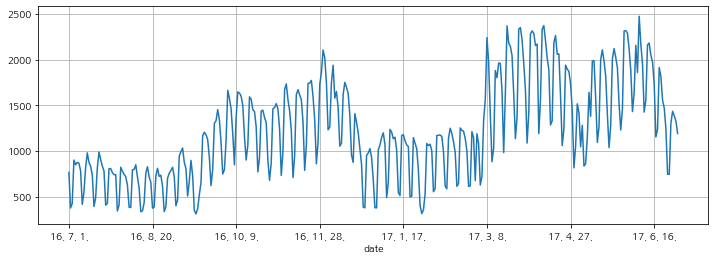

In [12]:
pinkwink_web['hit'].plot(figsize=(12,4), grid=True);

단순하게 2016년 7월 1일부터 2017년 6월 16일 까지 유입량을 그려봤다. 어떤 주기성이 있을 것 같은데 시간 순으로 되어 있는 데이터를 그냥 봐서는 정확하게 잘 모른다. 물론 유심히 관찰하면 2016년 11월 28일 부터 2017년 4월 27일 정도로 약 6개월의 주기성 정도는 육안으로 확인된다. 하지만 좀 더 주기성이 있다면 확인하고 싶다.

In [13]:
time = np.arange(0,len(pinkwink_web))
traffic =  pinkwink_web['hit'].values

fx = np.linspace(0,time[-1], 1000)


먼저 시간축(time)을 만들고 웹 트래픽의 자료를 traffic 변수에 저장한다. 지금 우리는 위 결과로 보이는 그래프를 설명할 간단한 함수를 찾으려 한다. 그게 직선일 수도 있고 혹은 다항식으로 표현되는 곡선일 수도 있다. 어쨋든 현재 데이터를 간단한 모델로 표현하고 싶다는 뜻이다. 이런 작업을 보통 회귀라 한다. 그래서 모델을 1차,2차,3차,15차 다항식으로 표현하고 그 결과를 확인해보자.

In [14]:
def error(f,x,y):
     return np.sqrt(np.mean((f(x)-y)**2))

어떤 데이터를 어떤 모델로 표현하려고 하면 그 모델의 적합성을 확인하는 과정이 필요하다. 그러기 위해서는 참 값과 비교해서 에러를 계산해야한다.

In [15]:
fp1 = np.polyfit(time, traffic, 1)
f1 = np.poly1d(fp1)

f2p = np.polyfit(time, traffic, 2)
f2 = np.poly1d(f2p)

f3p = np.polyfit(time, traffic, 3)
f3 = np.poly1d(f3p)

f15p = np.polyfit(time, traffic, 15)
f15 = np.poly1d(f15p)

print(error(f1, time, traffic))
print(error(f2, time, traffic))
print(error(f3, time, traffic))
print(error(f15, time, traffic))

430.8597308110963
430.6284101894695
429.53280466762925
330.47773078232495


1장에서 사용했던 polyfit과 poly1d를 사용해서 함수로 표현할 수 있다.

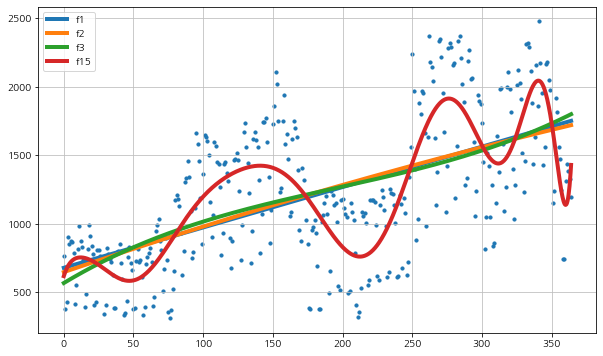

In [16]:
plt.figure(figsize=(10,6))
plt.scatter(time, traffic, s=10)

plt.plot(fx, f1(fx), lw=4, label='f1')
plt.plot(fx, f2(fx), lw=4, label='f2')
plt.plot(fx, f3(fx), lw=4, label='f3')
plt.plot(fx, f15(fx), lw=4, label='f15')

plt.grid(True, linestyle='-', color='0.75')

plt.legend(loc=2)
plt.show()

위 데이터를 1,2,3,15차 함수로 표현한 결과를 보자. 1차,2차,3차가 정의된 함수에서 에러를 확인해 보니 왜 큰 차이가 없는지 알 수 있다. 결국 2차나 3차로 표현하려면 그냥 1차로 표현하는 것이 나아보인다. 그렇다고 15차 함수를 사용해서 표현하는 것은 과적합일 수 있다. 하지만 위 그래프로는 어떤 결론을 내려야 할지 잘 모르기 때문에 앞으로의 데이터도 예측해보자.

## 7-2 prophet 모듈을 이용한 forecast 예측


prophet 모듈은 사용법이 아주 간단하다. 앞에서 받은 pinkwink_web 변수에서 날짜(index)와 방문수(hit)만 따로 저장한다.

In [17]:
df = pd.DataFrame({'ds':pinkwink_web.index, 'y':pinkwink_web['hit']})
df.reset_index(inplace=True)
df['ds'] =  pd.to_datetime(df['ds'], format="%y. %m. %d.")
del df['date']

m = Prophet(yearly_seasonality=True, daily_seasonality=True)
m.fit(df);

그리고 날짜를 pandas가 지원하는 to_datetime 함수를 이용해서 날짜라고 선언한다. 그리고 Prophet 함수를 사용할 때 주기성이 연단위로 있다고 알려준다.

In [18]:
future = m.make_future_dataframe(periods=60)
future.tail()

,ds
420,2017-08-25
421,2017-08-26
422,2017-08-27
423,2017-08-28
424,2017-08-29


이제 이후 60일 간의 데이터를 예측하고 싶다고 make_future_dataframe 명령하면 된다.

In [19]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
420,2017-08-25,905.470470,702.850827,1119.933179
421,2017-08-26,490.545920,282.687275,693.790768
422,2017-08-27,623.104992,407.370195,834.795278
423,2017-08-28,1175.626329,976.945547,1403.084649
424,2017-08-29,1211.572042,1001.625594,1417.789128


그리고 예측한 데이터를 forecast 변수에 저장한다.

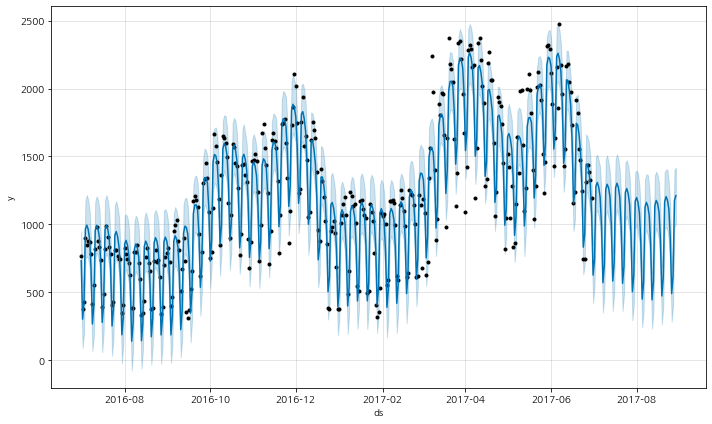

In [20]:
m.plot(forecast);

우리가 받은 2017년 6월 말까지의 데이터 이후 약 2개월 의 예측 결과가 위에 나타나 있다. 단순히 다항식으로 경향을 파악하는 것보다는 뭔가 나아 보인다.

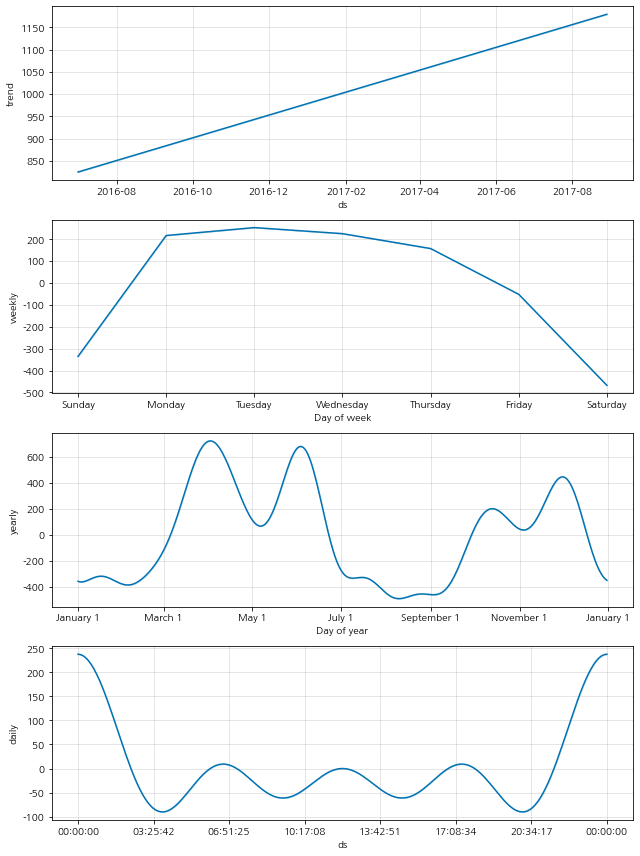

In [21]:
m.plot_components(forecast);

위와 같이 components 명령으로 재미있는 결과를 얻을 수 있다.
전체적인 경향은 직선으로 표현된다. 

Prophet을 사용해서 앞으로의 예측부터 주별, 연간 데이터의 현황도 알수 있게 되었다. 이러한 과정을 Seasonal 시계열 데이터 분석이라고 한다.

## 7-3 Seasonal 시계열 분석으로 주식 데이터 분석하기

In [1]:
pip install yfinance --upgrade --no-cache-dir

    100% |████████████████████████████████| 9.5MB 6.3MB/s ta 0:00:0111
    100% |████████████████████████████████| 13.4MB 7.1MB/s ta 0:00:011
    100% |████████████████████████████████| 61kB 7.2MB/s ta 0:00:011
    100% |████████████████████████████████| 5.5MB 7.6MB/s ta 0:00:011
    100% |████████████████████████████████| 235kB 8.6MB/s ta 0:00:011
    100% |████████████████████████████████| 512kB 7.4MB/s ta 0:00:011
    100% |████████████████████████████████| 184kB 7.7MB/s ta 0:00:011
    100% |████████████████████████████████| 61kB 7.2MB/s ta 0:00:011
    100% |████████████████████████████████| 153kB 8.8MB/s ta 0:00:011
    100% |████████████████████████████████| 153kB 6.7MB/s eta 0:00:01
  Running setup.py install for multitasking ... done
  Running setup.py install for yfinance ... done
Note: you may need to restart the kernel to use updated packages.


Pandas는 구글이 제공하는 주가 정보를 받아올 수 있는 기능이 있다. 바로 DataReader 함수이다. 종목 코드를 알면 한국 kospi 주가 정보도 받아올 수 있다.

In [3]:
from pandas_datareader import data
import yfinance as yf
yf.pdr_override()

start_date = '1990-1-1' 
end_date = '2017-6-30' 
KIA = data.get_data_yahoo('000270.KS', start_date, end_date)

KIA.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,7404.519043,7665.241699,7300.229980,7665.241699,5565.034668,636300
2000-01-05,7404.519043,7404.519043,7248.085449,7248.085449,5262.176758,686100
2000-01-06,7331.516602,7519.236816,6935.218262,6935.218262,5035.031738,379000
2000-01-07,6987.362793,7143.796387,6778.785156,6778.785156,4921.458984,701400
2000-01-10,6841.358398,7102.081055,6810.071777,7091.651855,5148.604004,1076700


기아자동차의 주가 정보를 받아서 간단하게 종가 기준으로 그래프를 그려보자.

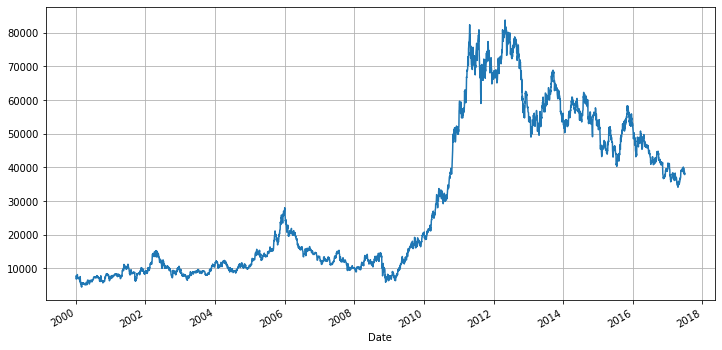

In [5]:
KIA['Close'].plot(figsize=(12,6), grid=True);

2012년 이후 전반적으로 하락하고 있다. 나중에 참 값과의 비교를 위해 일부 데이터를 잘라서 먼저 forecast를 수행해 보자.

In [6]:
KIA_trunc = KIA[:'2016-12-31']
KIA_trunc

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,7404.519043,7665.241699,7300.229980,7665.241699,5565.034668,636300
2000-01-05,7404.519043,7404.519043,7248.085449,7248.085449,5262.176758,686100
2000-01-06,7331.516602,7519.236816,6935.218262,6935.218262,5035.031738,379000
2000-01-07,6987.362793,7143.796387,6778.785156,6778.785156,4921.458984,701400
2000-01-10,6841.358398,7102.081055,6810.071777,7091.651855,5148.604004,1076700
...,...,...,...,...,...,...
2016-12-23,38700.000000,39350.000000,38650.000000,39100.000000,34615.121094,1070783
2016-12-26,39100.000000,39350.000000,38850.000000,39000.000000,34526.593750,465612
2016-12-27,39050.000000,39700.000000,39050.000000,39500.000000,34969.242188,879686


In [22]:
df = pd.DataFrame({'ds':KIA_trunc.index, 'y':KIA_trunc['Close']})
df.reset_index(inplace=True)
del df['Date']
df.head()

,ds,y
0,2000-01-04,7665.241699
1,2000-01-05,7248.085449
2,2000-01-06,6935.218262
3,2000-01-07,6778.785156
4,2000-01-10,7091.651855


위 처럼 별도로 데이터 프레임을 만든다.

그리고 1년 후 정보를 예측해 보자.

In [25]:
m = Prophet(daily_seasonality=True)
m.fit(df);

In [26]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
4660,2017-12-25
4661,2017-12-26
4662,2017-12-27
4663,2017-12-28
4664,2017-12-29


In [30]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4660,2017-12-25,36347.752492,28467.932943,44685.534845
4661,2017-12-26,36391.614754,28895.483273,45006.348571
4662,2017-12-27,36350.453850,28339.449375,44723.023010
4663,2017-12-28,36310.968134,28475.479110,43984.003426
4664,2017-12-29,36252.707655,27769.479995,44758.341274


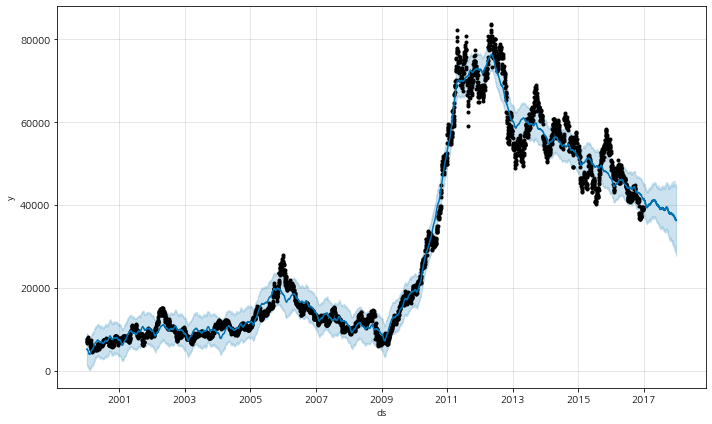

In [31]:
m.plot(forecast);

앞의 그래프와 뒷부분의 결과가 비슷해 보인다.

plot_components로 요소별로 확인해 보자.

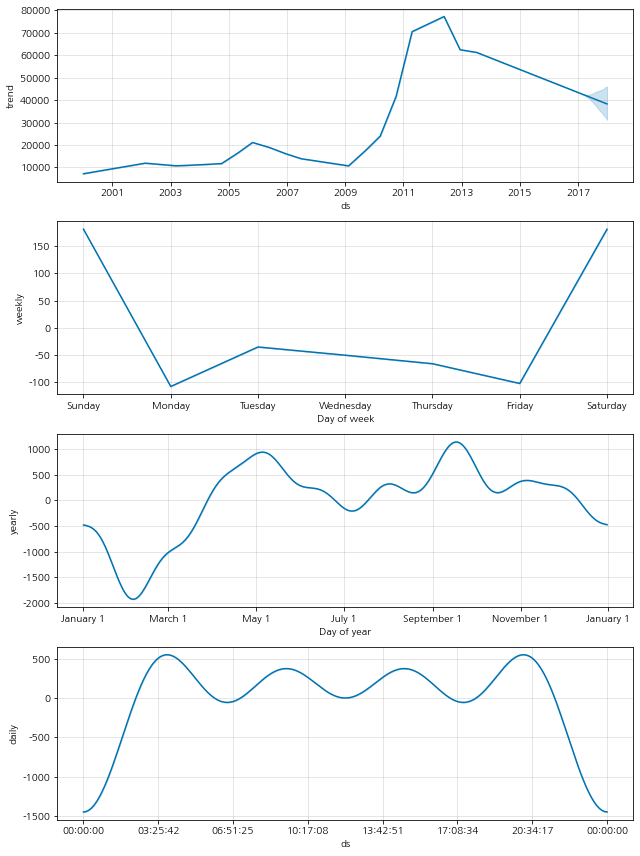

In [32]:
m.plot_components(forecast);

전체적인 trend 경향이 나타난다. 예측하라고 한 부부은 반등되거나 혹은 그대로 내려갈 수 도 있을듯 하다.

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

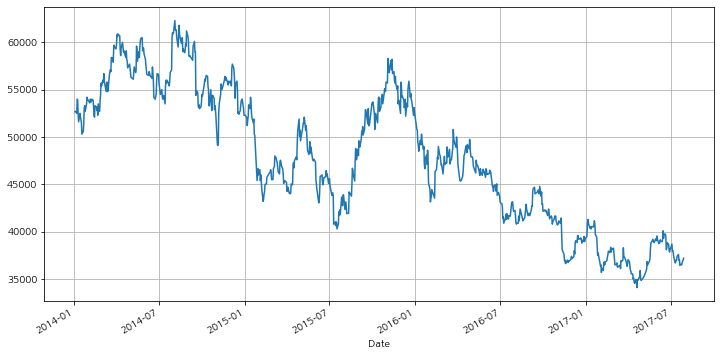

In [33]:
start_date = '2014-1-1' 
end_date = '2017-7-31' 
KIA = data.get_data_yahoo('000270.KS', start_date, end_date)
KIA['Close'].plot(figsize=(12,6), grid=True)

위 그래프는 주가를 가져오는 날짜를 바꿔서 다시 예측 성능을 확인해 보겠다.


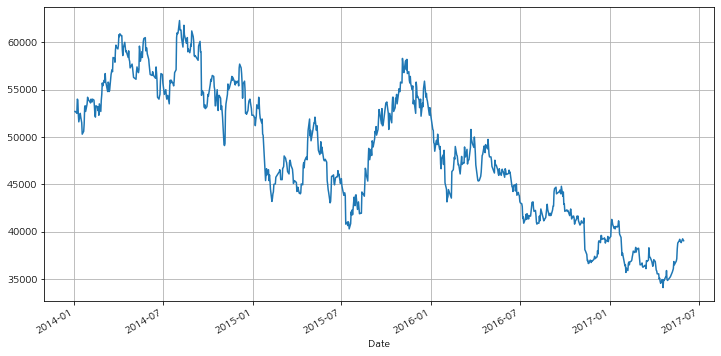

In [35]:
KIA_trunc = KIA[:'2017-05-31']
KIA_trunc['Close'].plot(figsize=(12,6), grid=True);

In [37]:
df = pd.DataFrame({'ds':KIA_trunc.index, 'y':KIA_trunc['Close']})
df.reset_index(inplace=True)
del df['Date']

데이터를 약간 손을 보고 이제 61일간 데이터를 예측해 보자.

In [38]:
m = Prophet(daily_seasonality=True)
m.fit(df);

In [39]:
future = m.make_future_dataframe(periods=61)
future.tail()

,ds
897,2017-07-27
898,2017-07-28
899,2017-07-29
900,2017-07-30
901,2017-07-31


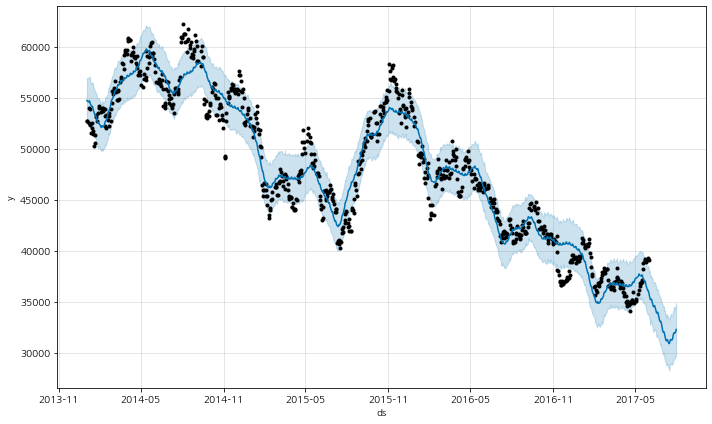

In [40]:
forecast = m.predict(future)
m.plot(forecast);

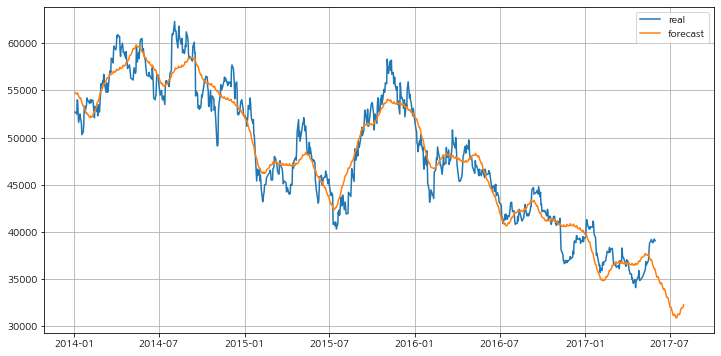

In [41]:
plt.figure(figsize=(12,6))
plt.plot(KIA.index, KIA['Close'], label='real')
plt.plot(forecast['ds'], forecast['yhat'], label='forecast')
plt.grid()
plt.legend()
plt.show()

우리는 그 후 2개월 데이터의 참 값을 알고 있으므로 직접 비교해볼 수 있다.
이렇게 참 값과 예측 값을 같이 두고 그래프로 그리는 것이다.

출처 : 파이썬으로 데이터 주무르기